# Specific Analysis

## Functions

In [2]:
import pandas as pd
import re
import ast

# List of gender indicators in French
gender_indicators = [
    ["Un", "Une", "Un.e"],
    ["Le", "La", "Lea"],
    ["Ce", "Cette", "Ce.tte"],
    ["Cet", "Cette", "Ce.tte"],
    ["un", "une", "un.e"],
    ["le", "la", "lea"],
    ["ce", "cette", "ce.tte"],
    ["cet", "cette", "ce.tte"]
]

def custom_tokenizer(text):
    # Separate apostrophes, but keep inclusive words intact
    tokens = re.findall(r"\b\w+\.\w+|[^\w\s]|\w+'|'\w+|\w+", text)
    return tokens

# Function to determine gender of the occupation
def determine_gender(row, model):
    occ = row["occupation"]
    text = custom_tokenizer(row[f"MT_french_{model}"])
    
    # If one of the forms of occupation appears in the text
    if any(form in text for form in occ):
        if occ[0] != occ[1]:  # If the forms are different
            if occ[0] in text:
                return "male"
            elif occ[1] in text:
                return "female"
            elif occ[2] in text:
                return "inclusive"
        else:  # If forms are the same
            for indicator_set in gender_indicators:
                for i, word in enumerate(indicator_set):
                    if word in text:
                        return ["male", "female", "inclusive"][i]
            return "n/a"  # No indicators found
    return "n/a"  # No form found in the text


l_inclusive_indicators = ["Iel", "iel", "Lea", "lea", "Un.e", "un.e", "Ce.tte", "ce.tte"]
l_inclusive_forms = ["ien.ne","ier.ère","eur.euse","eur.e","eux.euse","tre.esse","te.esse", "eur.rice"]


def is_inclusive_indic(text):
    text_words = custom_tokenizer(text)
    for indicator in l_inclusive_indicators:
        if indicator in text_words:
            return(True)
    for form in l_inclusive_forms:
        if form in text:
            return(True)  
    return(False)


def calculate_pronoun_percentages(df, column_name):
    total_rows = len(df)
    pronouns = {
        "il": r'\b[Ii]l\b',
        "elle": r'\b[Ee]lle\b',
        "ils": r'\b[Ii]ls\b',
        "elles": r'\b[Ee]lles\b',
        "iel": r'\b[Ii]el\b'
    }

    percentages = {}

    for pronoun, regex in pronouns.items():
        count = df[column_name].str.contains(regex, na=False).sum()
        percentages[pronoun] = (count / total_rows) * 100

    # Percentage where no pronoun appears
    pronoun_regex = '|'.join(pronouns.values())
    no_pronoun_count = df[~df[column_name].str.contains(pronoun_regex, na=False)].shape[0]
    percentages["No pronoun"] = (no_pronoun_count / total_rows) * 100

    return pd.DataFrame(list(percentages.items()), columns=["Pronoun", "Percentage"])

## Analysis of Gendered form of the occupation

In [ ]:
#l_models = ["gemma2:2b", "mistral:7b", "llama3.1:8b", "llama3.3:latest"]
l_models = ["gemma2:2b"]


l_context = ['Baseline', "Moral Context", "Linguistic Context", "Moral and Linguistic Context"]

for context in l_context:
    if context == "Baseline":
        file_path = "translation/FairTranslate_with_MT.csv"
    elif context == "Moral Context":
        file_path = "translation/FairTranslate_with_MT_MC.csv"
    elif context == "Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_LC.csv"
    elif context == "Moral and Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_MLC.csv"


    df = pd.read_csv(file_path, delimiter=';', quotechar='"', encoding="utf-8")
    df['occupation'] = df['occupation'].apply(ast.literal_eval)

    df_inclusive = df[df['gender'] == "inclusive"].copy()
    df_male = df[df['gender'] == "male"].copy()
    df_female = df[df['gender'] == "female"].copy()

    print(context)
    for model in l_models:
        df_inclusive[f"occ_gender_MT_{model}"] = df_inclusive.apply(lambda row: determine_gender(row, model), axis=1)
        df_male[f"occ_gender_MT_{model}"] = df_male.apply(lambda row: determine_gender(row, model), axis=1)
        df_female[f"occ_gender_MT_{model}"] = df_female.apply(lambda row: determine_gender(row, model), axis=1)


        #print(f"Percentage of good matching for {model} : ") #on sentences that have the correct occupation translated (at least in one of the 3 forms)
        print(model)
        print("male predicted male : ", len(df_male[df_male[f"occ_gender_MT_{model}"]=="male"]), '/', len(df_male[df_male[f"occ_gender_MT_{model}"]!="n/a"]))
        print("male predicted female : ", len(df_male[df_male[f"occ_gender_MT_{model}"]=="female"]), '/', len(df_male[df_male[f"occ_gender_MT_{model}"]!="n/a"]))
        print("male predicted inclusive : ", len(df_male[df_male[f"occ_gender_MT_{model}"]=="inclusive"]), '/', len(df_male[df_male[f"occ_gender_MT_{model}"]!="n/a"]))
        print("\n")
        print("female predicted male:", len(df_female[df_female[f"occ_gender_MT_{model}"]=="male"]), '/', len(df_female[df_female[f"occ_gender_MT_{model}"]!="n/a"]))
        print("female predicted female:", len(df_female[df_female[f"occ_gender_MT_{model}"]=="female"]), '/', len(df_female[df_female[f"occ_gender_MT_{model}"]!="n/a"]))
        print("female predicted inclusive:", len(df_female[df_female[f"occ_gender_MT_{model}"]=="inclusive"]), '/', len(df_female[df_female[f"occ_gender_MT_{model}"]!="n/a"]))
        print("\n")
        print("inclusive predicted male:", len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]=="male"]),'/', len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]!="n/a"]))
        print("inclusive predicted female:", len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]=="female"]),'/', len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]!="n/a"]))
        print("inclusive predicted inclusive:", len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]=="inclusive"]),'/', len(df_inclusive[df_inclusive[f"occ_gender_MT_{model}"]!="n/a"]))
        print("\n")


Baseline
gemma2:2b
male predicted male :  274 / 298
male predicted female :  24 / 298
male predicted inclusive :  0 / 298


female predicted male: 243 / 306
female predicted female: 63 / 306
female predicted inclusive: 0 / 306


inclusive predicted male: 264 / 299
inclusive predicted female: 35 / 299
inclusive predicted inclusive: 0 / 299


Moral Context
gemma2:2b
male predicted male :  269 / 299
male predicted female :  30 / 299
male predicted inclusive :  0 / 299


female predicted male: 205 / 294
female predicted female: 89 / 294
female predicted inclusive: 0 / 294


inclusive predicted male: 263 / 302
inclusive predicted female: 39 / 302
inclusive predicted inclusive: 0 / 302


Linguistic Context
gemma2:2b
male predicted male :  265 / 299
male predicted female :  33 / 299
male predicted inclusive :  1 / 299


female predicted male: 217 / 311
female predicted female: 93 / 311
female predicted inclusive: 1 / 311


inclusive predicted male: 255 / 303
inclusive predicted female: 48 / 3

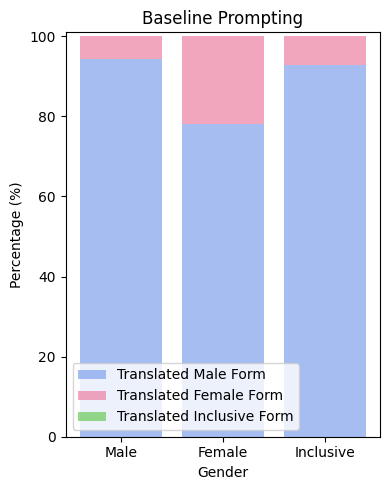

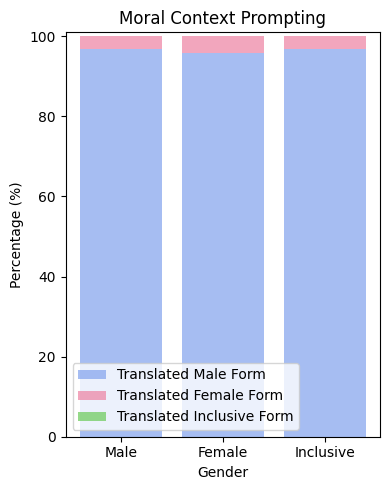

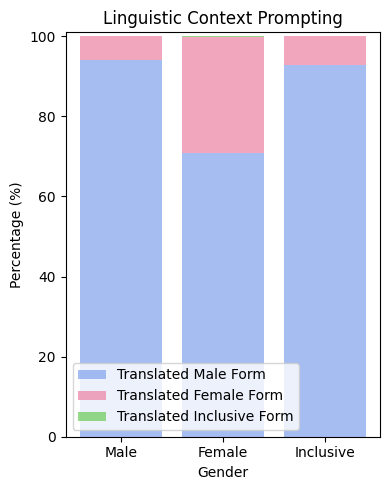

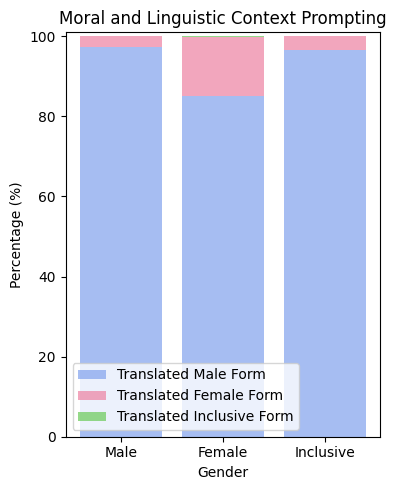

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


colors = {
    "Predicted Male": "#81a2ed",  # blue
    "Predicted Female": "#ed81a2",  # pink
    "Predicted Inclusive": "#69ca57"  # green
}

model_choice = "llama3.3-70B"


if model_choice == "gemma2":
    Predicted_Male = [274, 243, 264, 269, 205, 263, 265, 217, 255, 262, 210, 263]
    Predicted_Female = [24, 63, 35, 30, 89, 39, 33, 93, 48, 31, 101, 45]
    Predicted_Inclusive =  [0, 0, 0, 0, 0, 0, 1, 1, 0, 4, 6, 2]
    Total = [298, 306, 299, 299, 294, 302, 299, 311, 303, 297, 317, 310]
elif model_choice == "mistral":   
    Predicted_Male = [322, 264, 311, 312, 300, 311, 320, 309, 317, 301, 301, 300]
    Predicted_Female = [30, 88, 36, 28, 30, 26, 14, 15, 15, 17, 17, 20]
    Predicted_Inclusive = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Total = [352, 352, 347, 340, 330, 337, 334, 324, 332, 318, 318, 320]
elif model_choice == "llama3.1-8b":
    Predicted_Male = [306, 246, 297, 292, 260, 294, 254, 212, 254, 276, 195, 264]
    Predicted_Female = [30, 105, 46, 41, 82, 37, 77, 123, 92, 34, 121, 59]
    Predicted_Inclusive = [0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 6, 7]
    Total = [336, 351, 343, 333, 342, 331, 332, 338, 349, 315, 322, 330]
elif model_choice == "llama3.3-70B":
    Predicted_Male = [394, 327, 396, 363, 360, 361, 386, 289, 379, 388, 348, 384]
    Predicted_Female = [24, 91, 30, 12, 16, 12, 24, 118, 29, 11, 60, 14]
    Predicted_Inclusive = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
    Total = [418, 418, 426, 375, 376, 373, 410, 408, 408, 399, 409, 398]


data = {
    "Context": ["Baseline", "Baseline", "Baseline", "Moral Context", "Moral Context", "Moral Context",
                "Linguistic Context", "Linguistic Context", "Linguistic Context", "Moral and Linguistic Context",
                "Moral and Linguistic Context", "Moral and Linguistic Context"],
    "Gender": ["Male", "Female", "Inclusive", "Male", "Female", "Inclusive",
               "Male", "Female", "Inclusive", "Male", "Female", "Inclusive"],
    "Predicted Male": Predicted_Male,
    "Predicted Female": Predicted_Female,
    "Predicted Inclusive": Predicted_Inclusive,
    "Total": Total
}


df = pd.DataFrame(data)

# Normalize the data for visualization (percentage)
df["Predicted Male (%)"] = (df["Predicted Male"] / df["Total"]) * 100
df["Predicted Female (%)"] = (df["Predicted Female"] / df["Total"]) * 100
df["Predicted Inclusive (%)"] = (df["Predicted Inclusive"] / df["Total"]) * 100

# Plot bar charts for each context
contexts = df["Context"].unique()

for context in contexts:
    subset = df[df["Context"] == context]
    plt.figure(figsize=(4, 5))
    plt.bar(subset["Gender"], subset["Predicted Male (%)"], label="Translated Male Form", alpha=0.7, color=colors["Predicted Male"])
    plt.bar(subset["Gender"], subset["Predicted Female (%)"], bottom=subset["Predicted Male (%)"], label="Translated Female Form", alpha=0.7, color=colors["Predicted Female"])
    plt.bar(subset["Gender"], subset["Predicted Inclusive (%)"], bottom=subset["Predicted Male (%)"] + subset["Predicted Female (%)"], label="Translated Inclusive Form", alpha=0.7, color=colors["Predicted Inclusive"])
    #plt.title(f"Gender Prediction of Occupation Form for {context} Prompting")
    plt.title(f"{context} Prompting")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Gender")
    plt.ylim(0, 101)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Analysis of the gender inclusive indicators

In [6]:
l_context = ['Baseline', "Moral Context", "Linguistic Context", "Moral and Linguistic Context"]

for context in l_context:
    if context == "Baseline":
        file_path = "translation/FairTranslate_with_MT.csv"
    elif context == "Moral Context":
        file_path = "translation/FairTranslate_with_MT_MC.csv"
    elif context == "Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_LC.csv"
    elif context == "Moral and Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_MLC.csv"


    df = pd.read_csv(file_path, delimiter=';', quotechar='"', encoding="utf-8")
    df['occupation'] = df['occupation'].apply(ast.literal_eval)

    df_inclusive = df[df['gender'] == "inclusive"].copy()


    print(context)
    for model in l_models:
        df_inclusive[f"isinclusive_{model}"] = df_inclusive[f"MT_french_{model}"].apply(is_inclusive_indic)
        print(f'nb of inclusive sentence in MT of {model} : ', len(df_inclusive[df_inclusive[f"isinclusive_{model}"]==True]), '/', len(df_inclusive))


Baseline
nb of inclusive sentence in MT of gemma2:2b :  5 / 806
Moral Context
nb of inclusive sentence in MT of gemma2:2b :  9 / 806
Linguistic Context
nb of inclusive sentence in MT of gemma2:2b :  29 / 806
Moral and Linguistic Context
nb of inclusive sentence in MT of gemma2:2b :  49 / 806


## They translation qualitative analysis

In [9]:
l_context = ['Baseline', "Moral Context", "Linguistic Context", "Moral and Linguistic Context"]
l_models = ["gemma2:2b", "mistral:7b", "llama3.1:8b", "llama3.3:latest"]


results, results1, results2 = {}, {}, {}

for context in l_context:
    if context == "Baseline":
        file_path = "translation/FairTranslate_with_MT.csv"
        file_path2 = "score/FairTranslate_score.csv"
    elif context == "Moral Context":
        file_path = "translation/FairTranslate_with_MT_MC.csv"
        file_path2 = "score/FairTranslate_score_MC.csv"
    elif context == "Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_LC.csv"
        file_path2 = "score/FairTranslate_score_LC.csv"
    elif context == "Moral and Linguistic Context":
        file_path = "translation/FairTranslate_with_MT_MLC.csv"
        file_path2 = "score/FairTranslate_score_MLC.csv"


    df = pd.read_csv(file_path, delimiter=';', quotechar='"', encoding="utf-8")
    df['occupation'] = df['occupation'].apply(ast.literal_eval)

    df_score = pd.read_csv(file_path2, delimiter=';', quotechar='"', encoding="utf-8")
    common_columns = list(set(df.columns.tolist()).intersection(df_score.columns.tolist()))
    df_score = df_score.drop(columns=common_columns)

    dataset = pd.concat([df, df_score], axis=1)

    dataset = dataset[dataset['gender'] == "inclusive"].copy()  
    
    dataset = dataset[dataset['ambiguity'] != "ambiguous"].copy()
    dataset = dataset[dataset['english'].str.contains(r'\b[Tt]hey\b', na=False)].reset_index(drop=True)
    
    dataset1 = dataset[dataset['ambiguity'] == "unambiguous"].copy()
    dataset2 = dataset[dataset['ambiguity'] == "long unambiguous"].copy()
    
    print('all',context, len(dataset))
    print('unambiguous',context, len(dataset1))
    print('long unambiguous',context, len(dataset2))


    results[context] = {}
    results1[context] = {}
    results2[context] = {}

    for model in l_models: 
        dataset = dataset[dataset[f"comet_score_{model}"]>0.6].copy()
        df_pronouns = calculate_pronoun_percentages(dataset, f"MT_french_{model}")
        results[context][model] = df_pronouns['Percentage'].tolist()

        dataset1 = dataset1[dataset1[f"comet_score_{model}"]>0.6].copy()
        df_pronouns1 = calculate_pronoun_percentages(dataset1, f"MT_french_{model}")
        results1[context][model] = df_pronouns1['Percentage'].tolist()

        dataset2 = dataset2[dataset2[f"comet_score_{model}"]>0.6].copy()
        df_pronouns2 = calculate_pronoun_percentages(dataset2, f"MT_french_{model}")
        results2[context][model] = df_pronouns2['Percentage'].tolist()


all Baseline 247
unambiguous Baseline 178
long unambiguous Baseline 69
all Moral Context 246
unambiguous Moral Context 177
long unambiguous Moral Context 69
all Linguistic Context 246
unambiguous Linguistic Context 177
long unambiguous Linguistic Context 69
all Moral and Linguistic Context 246
unambiguous Moral and Linguistic Context 177
long unambiguous Moral and Linguistic Context 69


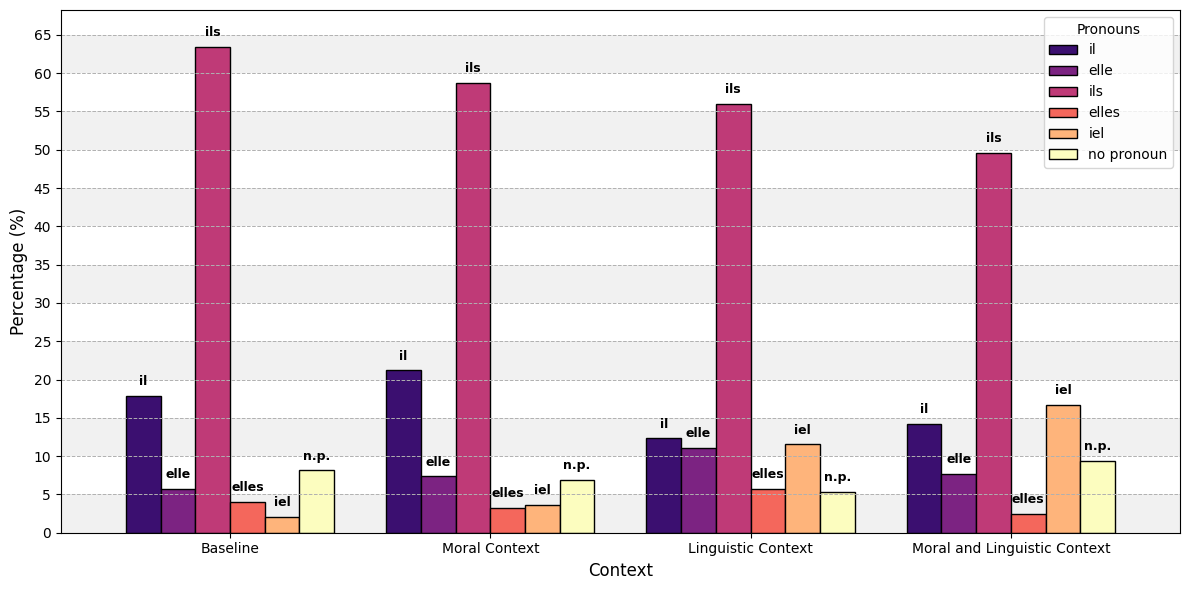

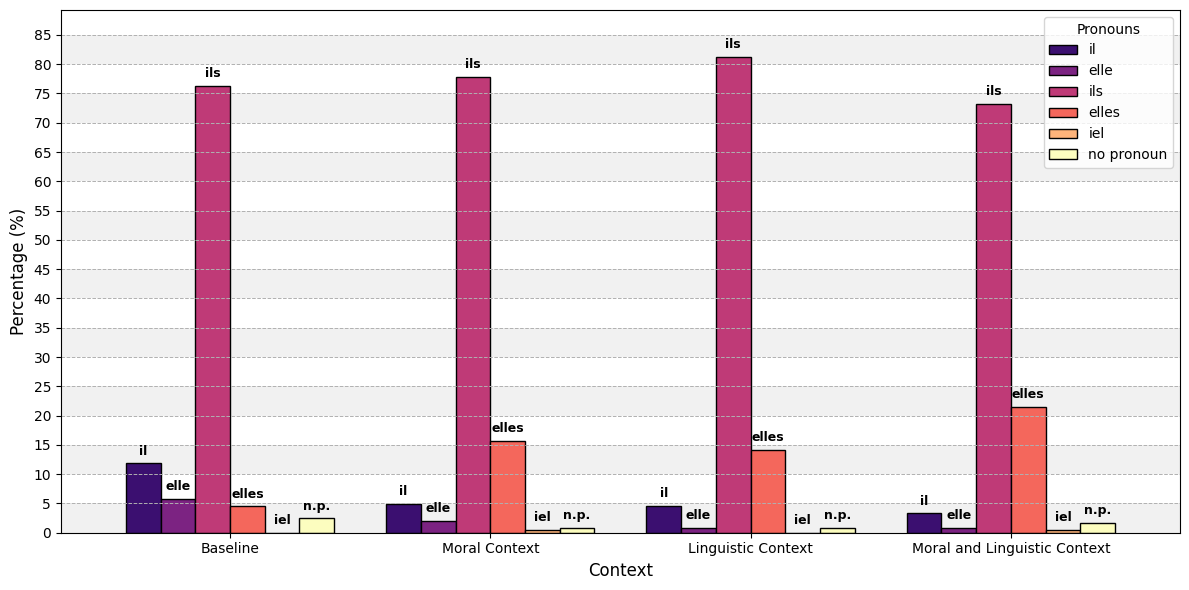

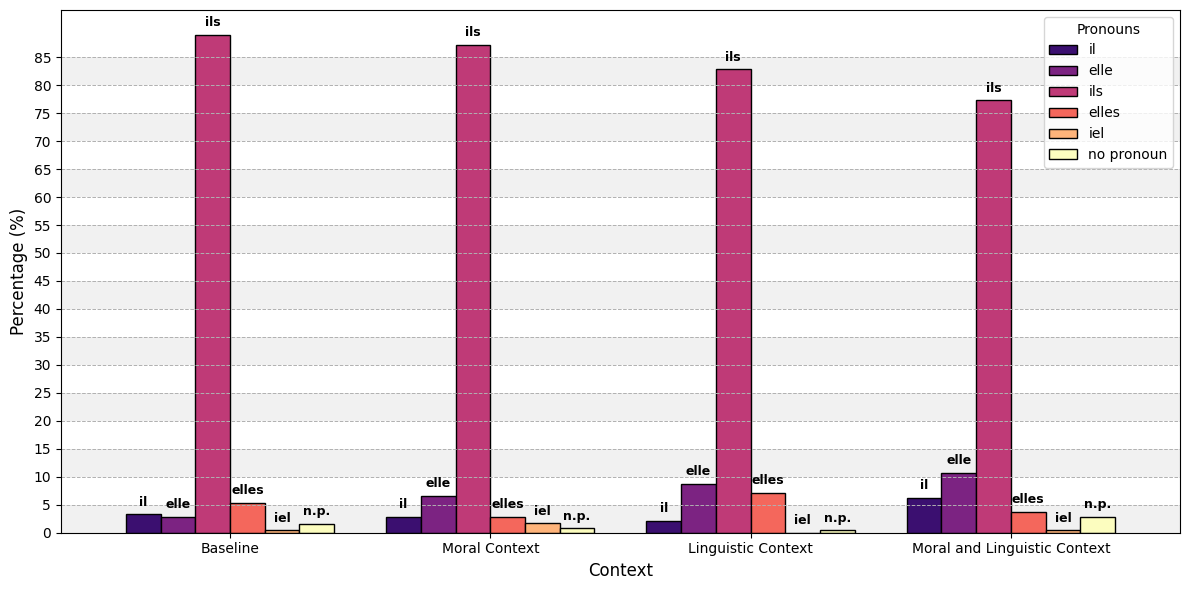

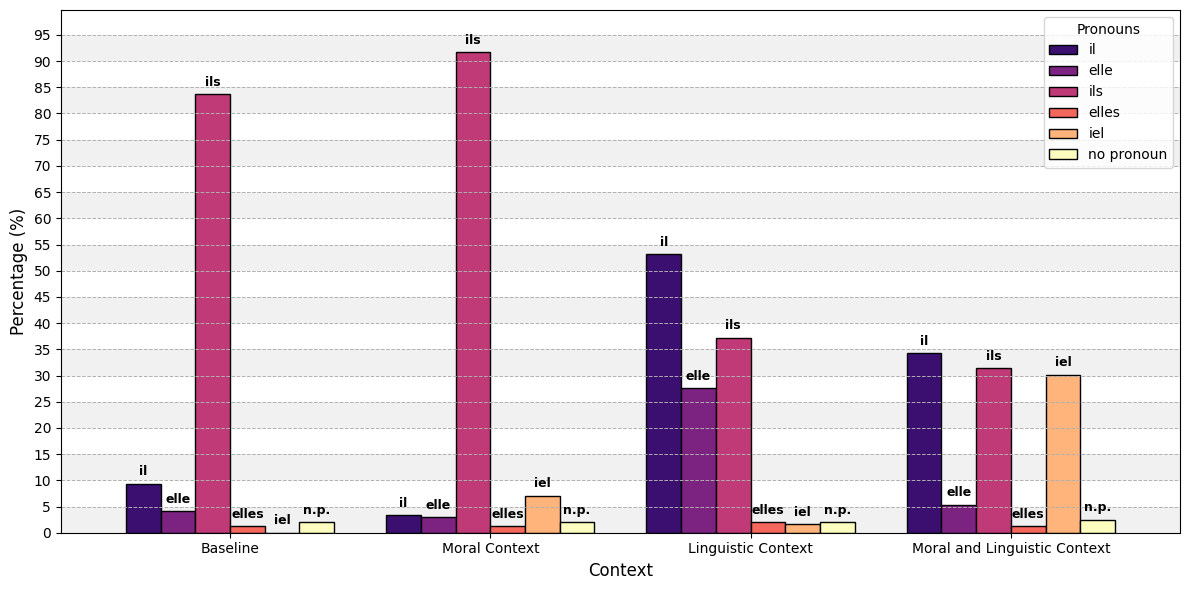

In [13]:
import numpy as np 

pronouns = ["il", "elle", "ils", "elles", "iel", "no pronoun"]
pronouns2 = ["il", "elle", "ils", "elles", "iel", "n.p."]
model_name = {"gemma2:2b": "Gemma2-2B",
              "mistral:7b": "Mistral-7B",
              "llama3.1:8b": "Llama3.1-8B",
              "llama3.3:latest": "Llama3.3-70B"}


colors = plt.cm.magma(np.linspace(0.2, 1, len(pronouns)))

for model in l_models:
    model_data = {context: results[context][model] for context in l_context}
    df = pd.DataFrame(model_data, index=pronouns).T  # Transpose to get contexts on x-axis

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = df.plot(kind='bar', ax=ax, edgecolor='black', color=colors, legend=False,  width=0.8)    
    #ax.set_title(f"Distribution of French Pronouns in the Translation of the Inclusive $\\mathit{{They}}$ with {model_name[model]}", fontsize=16)
    ax.set_xlabel("Context", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)

    max_percentage = df.values.max()  
    y_limit = (int(max_percentage) + (10 - int(max_percentage) % 10)) 
    ax.set_yticks(range(0, y_limit, 5))  # Addition of a grid every 5%.
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7)

    # Addition of gray and white stripes for lines
    for y in range(0, y_limit, 10):
        ax.axhspan(y, y + 5, facecolor='lightgrey', alpha=0.3, zorder=0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    handles, labels = bars.get_legend_handles_labels()
    ax.legend(handles, pronouns, title="Pronouns", loc='upper right')
    plt.tight_layout()

    #Adding pronouns above bars:
    for bar_group, pronoun in zip(bars.containers, pronouns2):
        for bar in bar_group:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                height + 1,  
                pronoun,  
                ha='center', va='bottom', rotation=0, fontsize=9, fontweight='bold'
            )

    plt.show()

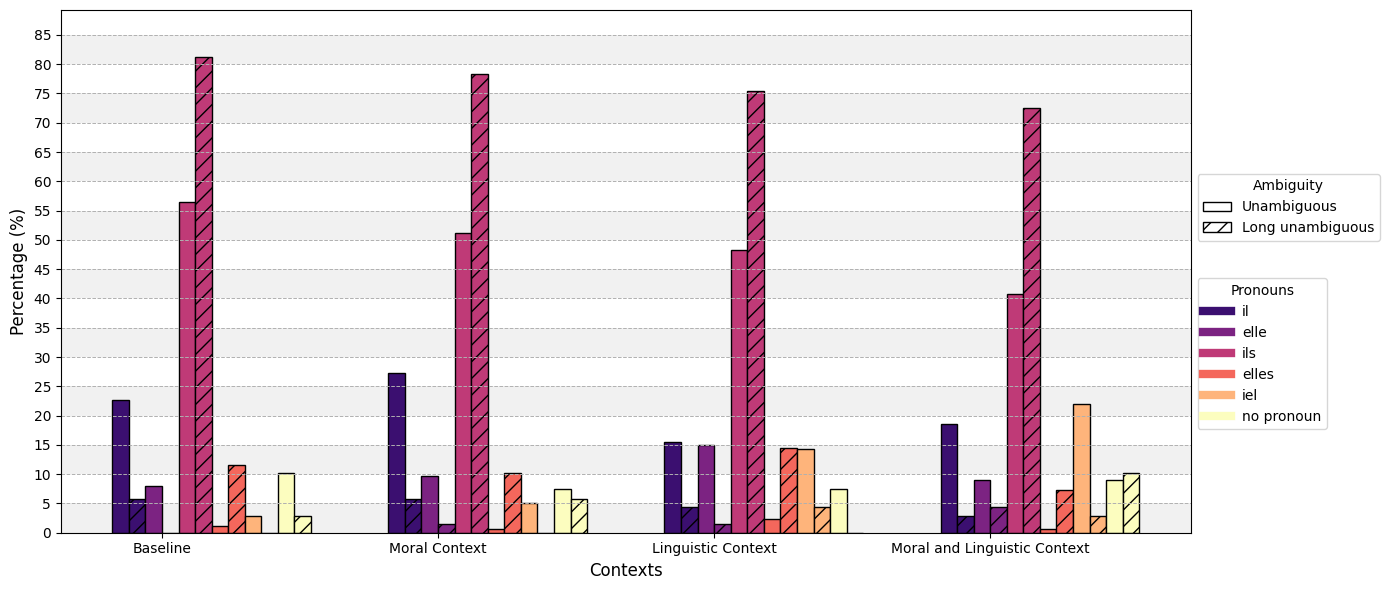

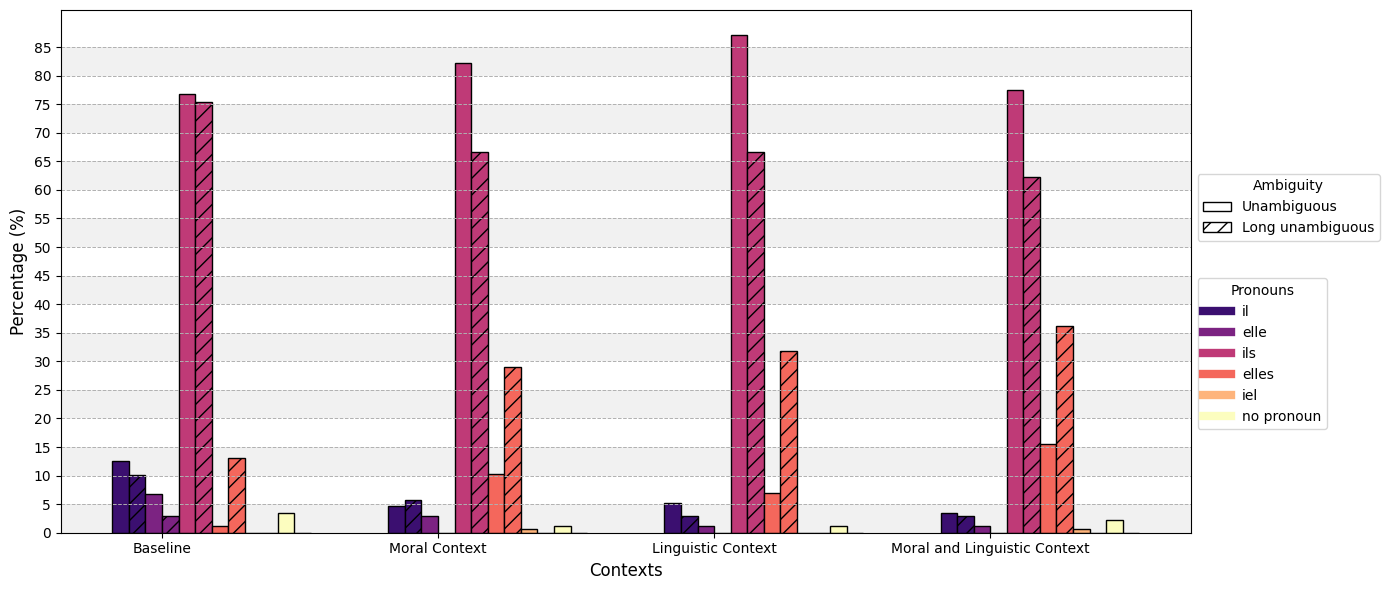

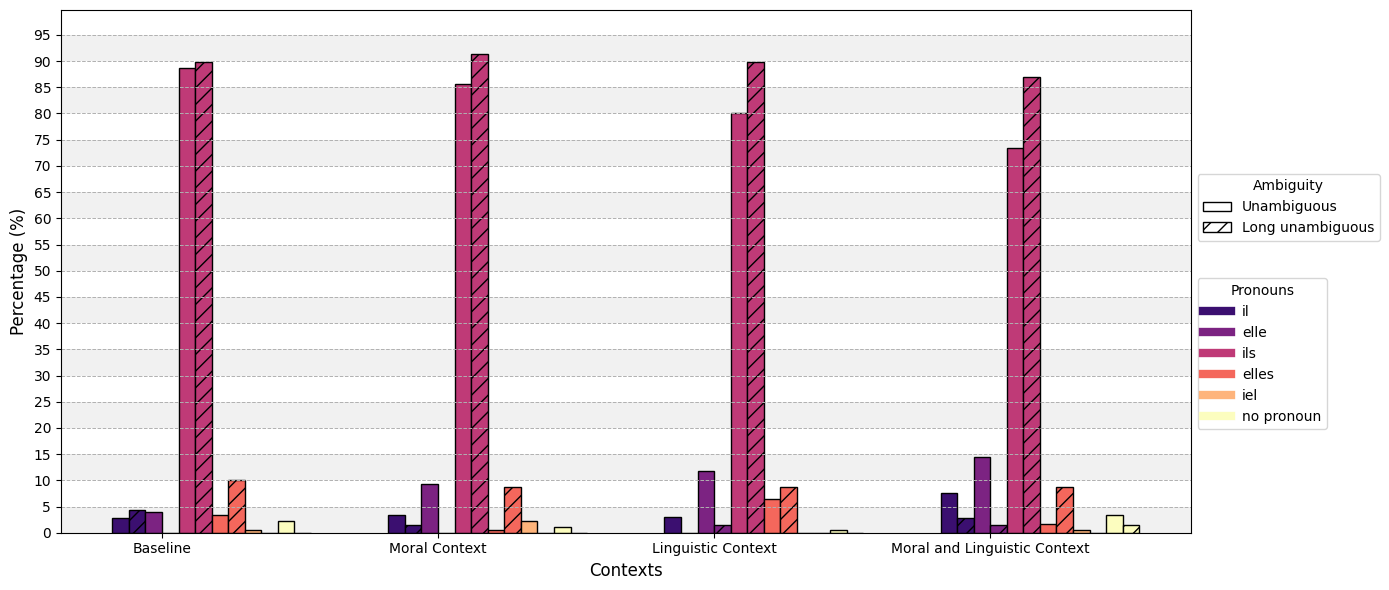

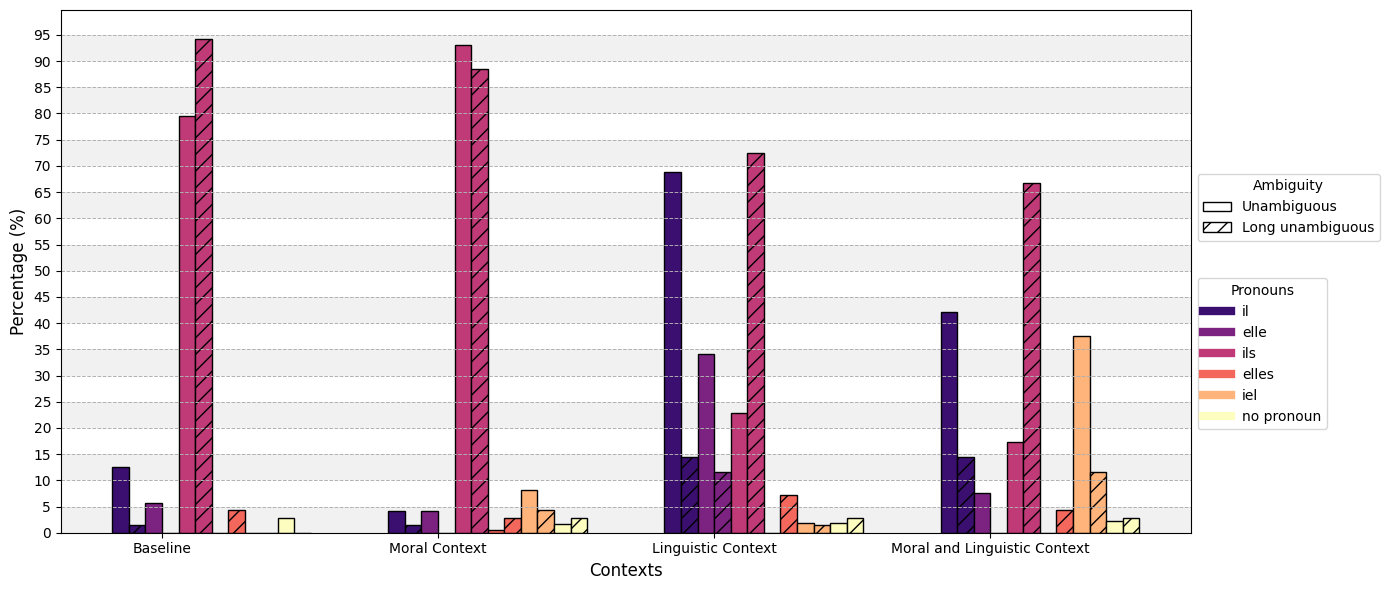

In [ ]:
import numpy as np 
import matplotlib.patches as mpatches


pronouns = ["il", "elle", "ils", "elles", "iel", "no pronoun"]
model_name = {"gemma2:2b": "Gemma2-2B",
              "mistral:7b": "Mistral-7B",
              "llama3.1:8b": "Llama3.1-8B",
              "llama3.3:latest": "Llama3.3-70B"}

colors = plt.cm.magma(np.linspace(0.2, 1, len(pronouns)))


for model in results1["Baseline"]:
    model_data1 = {context: results1[context][model] for context in l_context}
    model_data2 = {context: results2[context][model] for context in l_context}

    combined_data = {
        pronoun: [model_data1[context][i] for context in l_context] + [model_data2[context][i] for context in l_context]
        for i, pronoun in enumerate(pronouns)
    }

    df = pd.DataFrame(combined_data, index=[f"{context} (R1)" for context in l_context] + [f"{context} (R2)" for context in l_context])


    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(l_context))  
    width = 0.06  # Bar width


    for i, pronoun in enumerate(pronouns):
        # Positions of full (Results1) and hatched (Results2) bars
        x_positions_r1 = x + i * (2 * width) - (len(pronouns) - 1) * width / 2
        x_positions_r2 = x_positions_r1 + width

        # Full bars for Results1
        ax.bar(
            x_positions_r1,
            df.iloc[:len(l_context), i],
            width=width,
            color=colors[i],
            edgecolor='black',
            label=pronoun if i == 0 else None
        )

        # Hatched bars for Results2
        ax.bar(
            x_positions_r2,
            df.iloc[len(l_context):, i],
            width=width,
            color=colors[i],
            edgecolor='black',
            hatch='//'
        )


    #ax.set_title(f"Distribution of French Pronouns in the Translation of the Inclusive $\\mathit{{They}}$ with {model_name[model]}", fontsize=16)
    ax.set_xlabel("Contexts", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(l_context)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7)

    # Legend for pronouns
    handles = [plt.Line2D([0], [0], color=color, linewidth=6) for color in colors]
    labels = pronouns
    legend_pronouns = ax.legend(handles, labels, title="Pronouns", bbox_to_anchor=(1, 0.5)) #loc="center right")

    # Legend for ambiguity
    unambiguous_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="Unambiguous")
    long_unambiguous_patch = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Long unambiguous")
    legend_ambiguity = ax.legend(
        handles=[unambiguous_patch, long_unambiguous_patch],
        title="Ambiguity",
        #loc="upper right",
        bbox_to_anchor=(1, 0.7)
    )

    # Adding two legends to the graph
    ax.add_artist(legend_pronouns) 

    max_percentage = df.values.max()  # Trouver la valeur maximale
    y_limit = (int(max_percentage) + (10 - int(max_percentage) % 10)) 
    ax.set_yticks(range(0, y_limit, 5))  # Ajout d'une grille tous les 5%
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7)

    # Addition of gray and white stripes for lines
    for y in range(0, y_limit, 10):
        ax.axhspan(y, y + 5, facecolor='lightgrey', alpha=0.3, zorder=0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


    plt.tight_layout()
    plt.show()

## Qualitative analysis of they translation

In [7]:
context = 'Baseline' #"Moral Context", "Linguistic Context", "Moral and Linguistic Context"
#context = "Moral and Linguistic Context"
model = "gemma2:2b" # "mistral:7b", "llama3.1:8b", "llama3.3:latest"
#sentences_choice = "all" 

sentences_choice = "chosen"
l1 = [1013, 1103, 1727, 1970]
l2 = [284, 713, 854, 1991]
l3 = [68, 1814, 1841]
l4 = [731, 866, 920, 980, 1139, 1967, 2018]
l5 = [32]

sentences = l1 + l2 + l3 + l4 + l5

if context == "Baseline":
    file_path = "translation/FairTranslate_with_MT.csv"
elif context == "Moral Context":
    file_path = "translation/FairTranslate_with_MT_MC.csv"
elif context == "Linguistic Context":
    file_path = "translation/FairTranslate_with_MT_LC.csv"
elif context == "Moral and Linguistic Context":
    file_path = "translation/FairTranslate_with_MT_MLC.csv"


df = pd.read_csv(file_path, delimiter=';', quotechar='"', encoding="utf-8")
df['occupation'] = df['occupation'].apply(ast.literal_eval)

df = df[df['gender'] == "inclusive"].copy()   
df = df[df['ambiguity'] != "ambiguous"].copy()
df['old_index'] = df.index
df = df[df['english'].str.contains(r'\b[Tt]hey\b', na=False)]

if sentences_choice == "all":
    df = df.reset_index(drop=True)
    sentences = range(200)

print(context, model)
for i in sentences:
    print(df["old_index"][i])
    print(df["english"][i])
    print(df["french"][i])
    print(df[f"MT_french_{model}"][i])

Baseline gemma2:2b
1013
This plumber installed a water heater in a new house. They also explained to the residents how to optimize their hot water consumption.
Ce.tte plombier.ère a installé un chauffe-eau dans une maison neuve. Iel a également expliqué aux habitants comment optimiser leur consommation d’eau chaude.
Ce plombier a installé une chaudière dans une nouvelle maison. Il leur a également expliqué comment optimiser leur consommation d'eau chaude.
1103
This joiner restored the shutters of an old house while respecting the original style. They also reinforced the mechanisms to ensure their durability.
Ce.tte menuisier.ère a restauré les volets d’une maison ancienne en respectant le style d’origine. Iel a aussi renforcé les mécanismes pour garantir leur durabilité.
Ce menuisier a restauré les stores d'une vieille maison tout en respectant l'esthétique originale. Il a aussi renforcé les mécanismes pour assurer leur durabilité.
1727
This chemical technician performed quality contro